In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm
from scipy.stats.distributions import norm

# Gamma Ray Bursts

In the 1960's the US began the [Vela satellite program](https://en.wikipedia.org/wiki/Vela_(satellite), sending gamma ray detectors into space with the intention of monitoring the USSR for secret nuclear tests violating the Nuclear Test Ban Treaty during the cold war (image credit:[Los Alamos National Laboratory](https://en.wikipedia.org/wiki/Vela_satellite#/media/File:Vela5b.jpg)).

<img src="img/vela5b_5.gif" alt="Vela" style="width: 200px;"/>


These satellites picked up numerous bursts of gamma rays, but they were unlike anything seen during nuclear testing.

<img src="img/Neutron_Star_Merger_Still_2.jpg" alt="GRB" style="width: 500px;"/>

These bursts turned out to be cosmic, not terrestrial, in origin.  Know referred to as gamma ray bursts (GRBs), they are the brightest electromagnetic events known to happen in the universe (image credit:[NASA](https://fermi.gsfc.nasa.gov/)).

NASA's most recent mission to study these bursts is the Fermi Gamma Ray Space Telescope, which launched in 2008 (image credit:[NASA](https://www.nasa.gov/content/fermi/overview)).

<img src="img/fermi.jpg" alt="Fermi" style="width: 500px;"/>

To date, Fermi has detected more than 2000 GRBs.  In this project we're going to look at its observations of these GRBs, particularly how long the bursts last, to develop a better understanding of what these GRBs are.

## Load Data

In this repository I've included data downloaded directly from NASA's [Fermi GBM Burst Catalog](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermigbrst.html).  There are lots more data available for these events, but we're going to focus on the distribution of `T90`, the time taken to accumulate 90% of the burst fluence starting at the 5% fluence level (fluence is the radiant energy received by a surface -- the gamma ray detectors in this case -- per unit area, with units $\mathrm{J}/\mathrm{m}^2$).

In [3]:
# Lets establish a data type.  We'll be storing event names and T90 measurements
dtype=[('event', 'S12'), ('T90', np.float64)]
data = np.genfromtxt('Fermi_GRBs.txt', usecols=(1,4), skip_header=5, delimiter='|', dtype=dtype)

print(data)
print("{} events read.".format(len(data)))

[('GRB140323433', 111.426) ('GRB100325246', 8.192) ('GRB100507577', 44.033)
 ..., ('GRB121117018', 331.782) ('GRB160609690', 1.6)
 ('GRB090222179', 17.408)]
2210 events read.


There is one burst without a `T90` measurement, so let's remove it from our dataset.

In [4]:
data = data[~np.isnan(data['T90'])]
print("{} events left.".format(len(data)))

2209 events left.


# Distribution of `T90`

Now let's take a look at the distribution of `T90`.

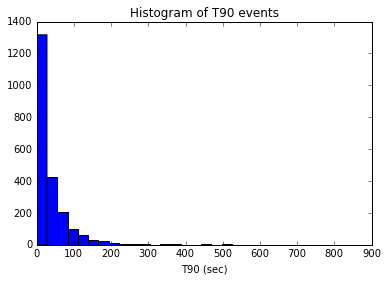

In [8]:
# Store T90 values in a dedicated array for convenience
T90 = data['T90']

plt.hist(T90, bins=30)
plt.title('Histogram of T90 events')
plt.xlabel('T90 (sec)')
plt.xlim(xmin=0);

It's hard to see any detail here, so let's use a log scale.

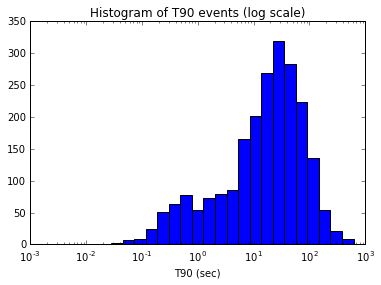

In [6]:
fig, ax = plt.subplots()

nbins = 30
bins = np.logspace(-3, 3, nbins)
plt.hist(data['T90'], bins=bins)
plt.title('Histogram of T90 events (log scale)')
plt.xlabel('T90 (sec)')
ax.set_xscale('log');

This looks kind of Gaussian...ish.  Let's try modeling it with a normal distribution.

Since this is $\log_{10} (\mathrm{T90})$ we should technically be using a log-Normal distribution, but since we've already used standard Gaussian mixture models we'll just analyze the $\log$ of the data.

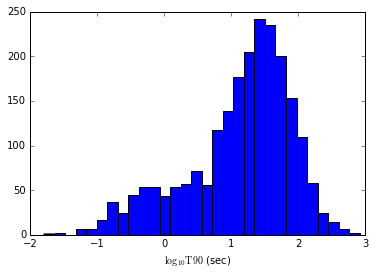

In [10]:
logT90 = np.log10(data['T90'])
plt.hist(logT90, bins=30)
plt.xlabel('$\log_{10}\mathrm{T90}$ (sec)');

## Gaussian model

Using the `logT90` dataset defined above, build a `PyMC3` Gaussian distribution model.  Describe each component of your model, describe the priors you use and why, identify which component is the likelihood.

In [8]:
# Gaussian model here

model = pm.Model()

with model:

    # subpopulation means
    mean = pm.Uniform('mean', logT90.min(), logT90.max())

    # subpopulation standard deviations
    sd = pm.HalfNormal('sd', logT90.max()-logT90.min())

    # likelihood for each observed value
    Obs = pm.Normal('obs', mu=mean, sd=sd, observed=logT90)

For my Guassian distribution model, I used a uniform prior since I have no prior knowledge about GRB's. I did not want to choose a prior that would impact that posterior estimate too heavily. I chose a half-normal distribution for the sigmas associated with the mean of my distribution. I figured that the scatter about the gaussian distribution would a normal distribution (chose half-normal for positive values). The likelihood of my model is a normal distribution (hence, the name Gaussian model). 

Sample the posterior for this model.  Show your traces and discuss them.  Did you get good sampling?  Are you sure your priors aren't too restrictive?

100%|██████████| 100500/100500 [01:33<00:00, 1076.64it/s]


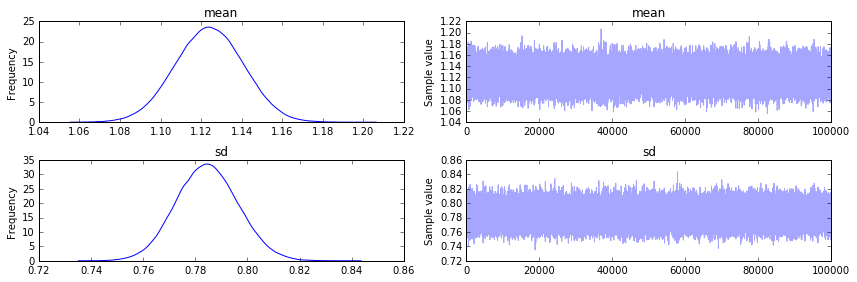

In [12]:
# Trace plots and discussion here

with model:
    trace = pm.sample(100000)
    
pm.traceplot(trace, ['mean', 'sd']);

The mean for my model sits at around 1.12 seconds and the standard deviation is about 0.8. The traces for my mean and standard deviation are very noisy which is a sign of good sampling. This indicates that the sampler did indeed jump around the histogram quite a bit and did not get stuck in one particular area. This is also means that my prior was not too restrictive. I chose as broad of a prior as I good as far as my mean and standard deviation. I set my mean to be restricted between the min and max of the distribution and I set my standard deviation to be the width of my whole distribution. 

Show the marginal posterior estimates for the parameters in your model.  What have we learned?

In [18]:
# Marginal posterior plots here
from scipy.stats.distributions import norm

def pos(sample):
    def func(xs):
        weights = [1.]
        means = [sample['mean']]
        stds = [sample['sd']]
        p = 0
        for weight, mean, std in zip(weights, means, stds):
            p += weight*norm.pdf(xs, loc=mean, scale=std)
        return p
    return func


In [19]:
n = 100
xs = np.linspace(logT90.min(), logT90.max(), 100)
posts = np.empty((n, len(xs)))
for i, sample in enumerate(np.random.choice(trace, size=n, replace=False)):
    posts[i] = pos(sample)(xs)

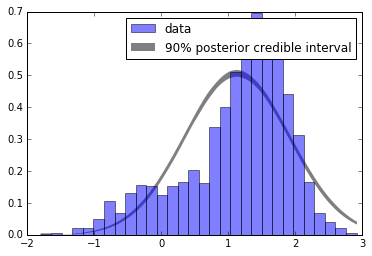

In [20]:
plt.hist(logT90, bins=30, normed=True, label='data', alpha=0.5)
plt.fill_between(xs, np.percentile(posts, 5, axis=0), np.percentile(posts, 95, axis=0), lw=0, label='90% posterior credible interval', color='k', alpha=0.5)
plt.legend()

From the graph above, we can tell that one Gaussian model is not enough to sufficiently fit the data. The trace is too broad and does not put forth any information regarding trends in GRB's. You can also see that there is a lot of data that outlies the Gaussian fit. This is a bad sign and we should consider a better way to fit the data. 

How well does your model fit the data.  You can show this by either plotting the posterior constraints for your model with the data, or doing posterior predictive checks and simulating data from your constrained model and comparing to the actual data.

In [21]:
# Compare to data here by doing a posterior predictive check
with model:
    ppc_trace = pm.sample_ppc(trace, 5000)

100%|██████████| 5000/5000 [00:04<00:00, 1194.64it/s]


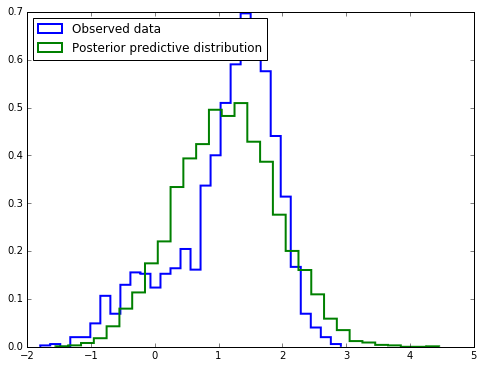

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(logT90, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['obs'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc='upper left');

Above is a simulated data set in green with the original data in blue. The idea of the posterior predictive check is to use the Gaussian model to randomly generate numbers and compare the simulated data to the orignal data. 

When we randomly sample numbers with our Gaussian model, we generate a histogram that is shifted the left of the orignal data set. The simulated data set is broad enough to encompass most of our orignal data set; however there is outliers that are evident as well. It is obvious that the data set should be split up into more than one section because of the peak that trends toward the longer bursts. If we were to restrict the mean to be towards the longer GRB's, we would be using our data set to restrict our prior, which is not a good idea. 

## Gaussian mixture model

Now lets use a 2-component Gaussian mixture model to better understand the data. Build a 2-component Gaussian mixture model. Describe each component of your model, describe the priors you use and why, identify which component is the likelihood.

In [11]:
# Gaussian mixture model here
mix_model = pm.Model()

k = 2 #Number of Guassian components

with mix_model:
    # subpopulation weights
    w = pm.Dirichlet('w', a=np.ones(k), shape=k)

    # subpopulation means
    means = pm.Uniform('means', logT90.min(), logT90.max(), shape=k)

    # subpopulation standard deviations
    sd = pm.HalfNormal('sd', sd=logT90.max()-logT90.min(), shape=k)
    
    # avoid the exchange symmetry to make sampling easier
    if k > 1:
        switchs = [pm.math.switch(means[c]-means[c-1] < 0, -np.inf, 0) for c in range(1, k)]
        order_means_potential = pm.Potential('order_means_potential', pm.math.sum(switchs))

    # latent subpopulation association of each observation
    category = pm.Categorical('category', p=w, shape=len(logT90))

    # likelihood for each observed value
    points = pm.Normal('obs', mu=means[category], sd=sd[category], observed=logT90)

The priors I used for my Gaussian mixture model include a uniform distribution about the two means for my subsets. This is mainly because I do not want to influence my posterior and make any mean have a higher probability than another. The standard deviation is similar to before and I used a half normal to restrict my values to positives only. I am hoping that the noise around the Gaussian mixture fit will not be too big which is why I chose a normal distribution for the sigmas. 

The weights in my model are drawn from a Dirichlet distribtuion. The Dirichlet distribution is mulit-dimensinal Beta distribution. I chose this distribution to simiulate the weights for my model because I did not want to influence where the data set would be pulled. Therefore, I guessed my prior weights to be all even (1.0 and 1.0). 

Lastly, my likehliood for each observed value is a normal distribution. The two data sets appeared that it could be split up into two seperate normal distributions. (hence, the name Gaussian mixture model). 

Sample the posterior for this model.  Show your traces and discuss them.  Did you get good sampling?  Are you sure your priors aren't too restrictive?

In [12]:
with mix_model:
    tr2 = pm.sample(10000)

# remove the first 1000 samples as burnin
tr2 = tr2[1000:]

100%|██████████| 10500/10500 [2:01:00<00:00,  1.45it/s]//anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.880603690322, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



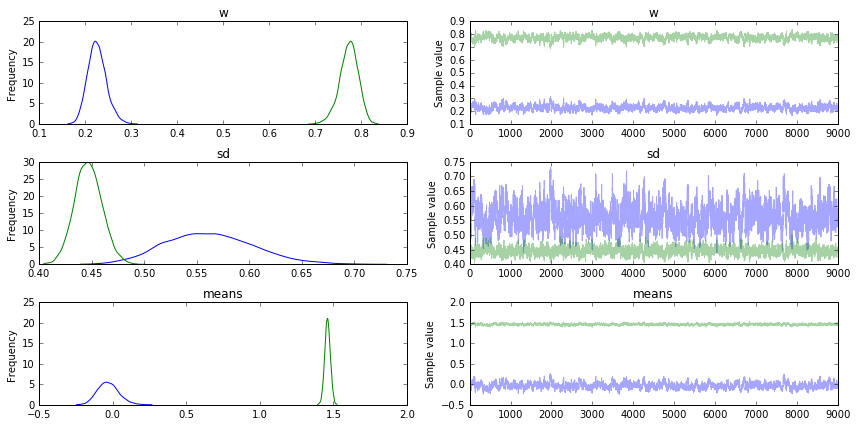

In [14]:
# Trace plots and discussion here
pm.traceplot(tr2, ['w', 'sd', 'means']);

There are two different Gaussian distributions that were fit to my data set. The blue one indicates the short time scale GRB's and the green indicates the long ones. I did get good sampling because both chains are very noisy. You can see that the blue one jumps into the green chain in the standard deviation but is able to get out of that subset without issue. This shows that the standard deviation constraint wasn't too restrictive. Although, the mean and the weight chains do not mix together, it is still safe to assume that my priors weren't too restrictive. The chains are noisy enough to indicate a fair amount of jumping in the histogram.

Show the marginal posterior estimates for the parameters in your model.  What have we learned?

In [15]:
# Marginal posterior plots here
def pos(sample):
    def func(xs):
        weights = sample['w']
        means = sample['means']
        stds = sample['sd']
        p = 0
        for weight, mean, std in zip(weights, means, stds):
            p += weight*norm.pdf(xs, loc=mean, scale=std)
        return p
    return func


In [17]:
n = 100
xs = np.linspace(logT90.min(), logT90.max(), 100)
posts = np.empty((n, len(xs)))
for i, sample in enumerate(np.random.choice(tr2, size=n, replace=False)):
    posts[i] = pos(sample)(xs)

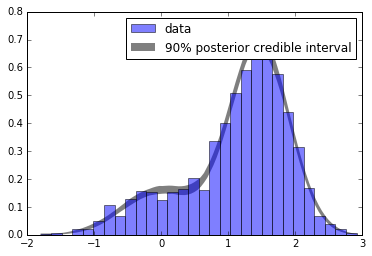

In [18]:
plt.hist(logT90, bins=30, normed=True, label='data', alpha=0.5)
plt.fill_between(xs, np.percentile(posts, 5, axis=0), np.percentile(posts, 95, axis=0), lw=0, label='90% posterior credible interval', color='k', alpha=0.5)
plt.legend()

From the above graph, we can see that the posterior estimate fits our data nicely. The 90% posterior credible interval indicates that the region between the two subsets has a wider credibility. This is because a data point in between this region may fall in between either subset. The observed data falls along the crediblility line and there is only a few outlying bars but they do not fall outside by much. We have learned that the observed data is close to our posterior estimate, but we can check this further down below by simulating some data. 

How well does your model fit the data.  You can show this by either plotting the posterior constraints for your model with the data, or doing posterior predictive checks and simulating data from your constrained model and comparing to the actual data.  How is your Gaussian mixture model performing compared to single Gaussian model above?

In [20]:
# Compare to data here
with mix_model:
    ppc_trace = pm.sample_ppc(tr2, 5000)

100%|██████████| 5000/5000 [00:05<00:00, 889.45it/s]


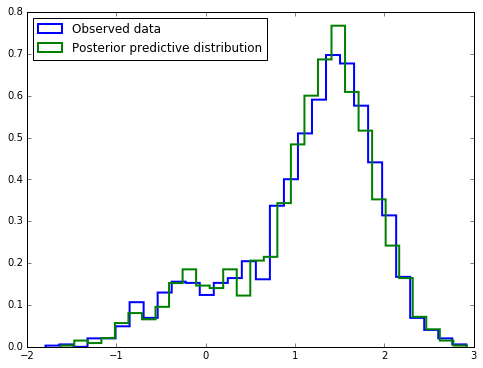

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(logT90, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['obs'][-1], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc='upper left');

The green line indicates our simulated data and the blue line indicated our orignial data set. The two histograms are fairly matched. This shows that our Gaussian mixture model fits our original data set well and much nicer than the orignal Gaussian model above. By random simulating data, we can show that there we did not bias our model in anyway and that our model is sound. 

The two subpopulations you have constrained here are thought to arise from very different processes.  The short-duration population, creatively named _short gamma ray bursts_, are believed to be from compact binary mergers with neutron stars (GW170817/GRB170817A is the first confirmation of this).  The _long gamma ray bursts_ are instead the death of massive stars, and are often associated with core-collapse supernovae.

From your posterior estimates above, what can you say about the fraction of detected GRBs that are short GRBs?

In [36]:
# Posterior estimate for detected fraction of short GRBs


Finally, lets determine the class of some specific GRBs.  For this you will need to have used a latent variable model, with categorical parameters describing the subpopulation type of each GRB.

What is the most likely GRB type for `GRB110717180`?  How certain is this association?  What about `GRB080808451`?

In [61]:
# Posterior estimates for associations of specific GRBs

#Name of 1st GRB we are looking at 
GRB1='GRB110717180'

#Taking the 1st GRB burst data and turning it into log scale 
GRB1_data=np.log10(0.112) 

#Name of 2nd GRB we are looking at
GRB2='GRB080808451'

#Taking the 2nd GRB burst data and turning it into log scale 
GRB2_data=np.log10(4.352)

In [46]:
data0_association = tr2['category'][:, 1400] #located at the 1406 spot in list, need to subract 6 elements due to shifting in data set

for subpop in range(k):
    prob = np.count_nonzero(data0_association == subpop)/len(data0_association)
    print("Posterior prob of {} for '{}' in subpopulation {}".format(prob, GRB1, category_names[subpop]))

Posterior prob of 1 for 'GRB110717180' in subpopulation Short GRB
Posterior prob of 0 for 'GRB110717180' in subpopulation Long GRB


For the 'GRB110717180', we are pretty certain that it belongs in the short GRB subpopulation. The GRB1_data variable is -0.9 which falls in the peak of the short GRB subpopoulation in our histogram; therefore we are pretty sure of it being a compact binary merger with a neutron star.  

In [57]:
data1_association = tr2['category'][:, 1190] #located at the 1196 spot

for subpop in range(k):
    prob = np.count_nonzero(data1_association == subpop)/len(data1_association)
    print("Posterior prob of {} in subpopulation {}".format(prob, subpop))

Posterior prob of 0 in subpopulation 0
Posterior prob of 0 in subpopulation 1


For the 'GRB080808451', we are not too certain of which subpopulation that data point will belong. Although the posterior prob is 0 in both (due to some issues with pointing float numbers), there is some probability of it being in one group verus another. The log scale of that data point is around 0.6. If we were to look at the graph, we see that it is around the tail end of both subpopulations. Therefore, this GRB could either be a compact binary merger with a neutron star or a death of a massive star. 

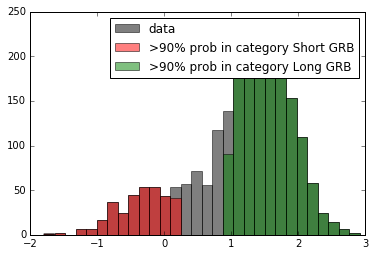

In [56]:
# Posterior estimates for associations of specific GRBs
_, bins, _ = plt.hist(logT90, color='k', bins=30, alpha=0.5, label='data')

for subpop, color in zip(range(k), ['r', 'g', 'b']):
    prob_in_subpop = np.mean(tr2['category']==subpop, axis=0)
    sel = prob_in_subpop > .9

    plt.hist(logT90[sel], bins=bins, label='>90% prob in category {}'.format(category_names[subpop]), color=color, alpha=0.5);
plt.legend();

## BONUS: 3-component mixture model

If you're too excited about Gaussian mixture models to stop now, build a 3-component mixture model and sample with it.  Does this do a better job of fitting the data? If so, how much better?  We haven't done this with `PyMC3`, but how might we go about determining which model is the more probable descriptor of the data?

In [38]:
# Gaussian mixture model here
threemix_model = pm.Model()

k = 3 #Number of Guassian components

with threemix_model:
    # subpopulation weights
    w = pm.Dirichlet('w', a=np.ones(k), shape=k)

    # subpopulation means
    means = pm.Uniform('means', logT90.min(), logT90.max(), shape=k)

    # subpopulation standard deviations
    sd = pm.HalfNormal('sd', sd=logT90.max()-logT90.min(), shape=k)
    
    # avoid the exchange symmetry to make sampling easier
    if k > 1:
        switchs = [pm.math.switch(means[c]-means[c-1] < 0, -np.inf, 0) for c in range(1, k)]
        order_means_potential = pm.Potential('order_means_potential', pm.math.sum(switchs))

    # latent subpopulation association of each observation
    category = pm.Categorical('category', p=w, shape=len(logT90))

    # likelihood for each observed value
    points = pm.Normal('obs', mu=means[category], sd=sd[category], observed=logT90)

In [39]:
with threemix_model:
    tr = pm.sample(10000)

# remove the first 1000 samples as burnin
tr = tr[1000:]

100%|██████████| 10500/10500 [1:52:26<00:00,  1.56it/s]//anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.211662364099, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
//anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 3367 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



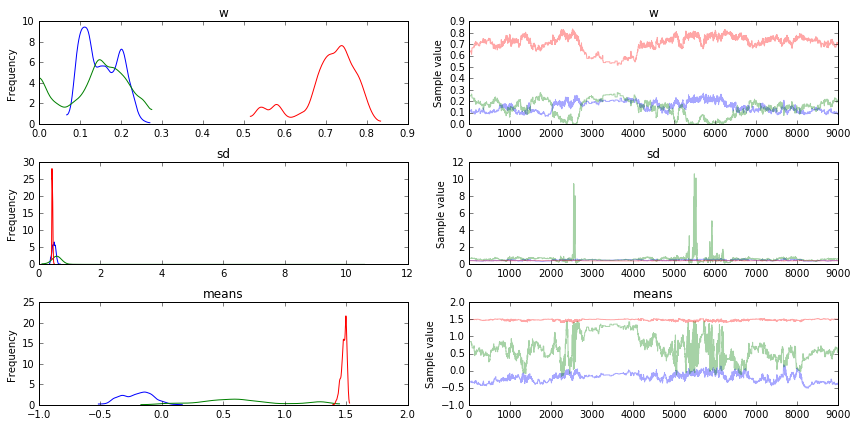

In [40]:
pm.traceplot(tr, ['w', 'sd', 'means']);

In [43]:
n = 100
xs = np.linspace(logT90.min(), logT90.max(), 100)
posts = np.empty((n, len(xs)))
for i, sample in enumerate(np.random.choice(tr, size=n, replace=False)):
    posts[i] = pos(sample)(xs)

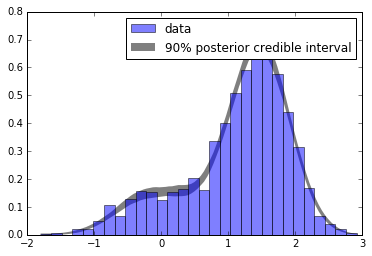

In [45]:
plt.hist(logT90, bins=30, normed=True, label='data', alpha=0.5)
plt.fill_between(xs, np.percentile(posts, 5, axis=0), np.percentile(posts, 95, axis=0), lw=0, label='90% posterior credible interval', color='k', alpha=0.5)
plt.legend()

In [47]:
with threemix_model:
    ppc_trace = pm.sample_ppc(tr, 5000)

100%|██████████| 5000/5000 [00:04<00:00, 1048.07it/s]


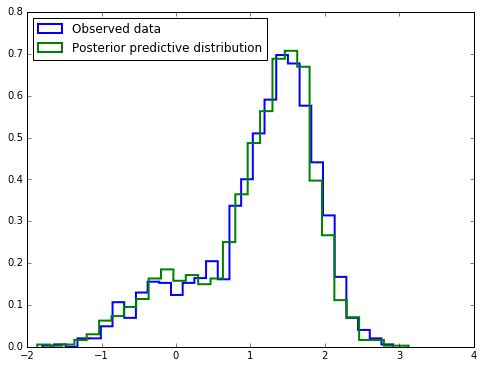

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(logT90, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['obs'][-1], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc='upper left');

The three-Gaussian mixture model seems to fit our data set very well. The random sampler for our posterior estimate closely matches our observed data set. However, if we look at our traceplots the medium GRB's tend to jump between the short and long GRB's. They do not have a their own sepereate chain. This is a bad sign because we may just be adding more parameters that do not give us any more knowledge about our data set. 

At the end of the day, any data set may be a represenation of many different Gaussian distributions. We could try to fit our Gaussian model better by adding more parameters into our mixture model; however, this is only a waste of time and inefficient. There is a always a tradeoff between efficiency and a good fit. Therefore, I would argue that the three Gaussian mixture model is going overboard in terms of what we know about GRB's. Since we know that GRB's normally fall into two subpopulations there is no reason to fit more than two Gaussian distributions. 